# Multi Head Attention

In [1]:
import numpy as np
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
%matplotlib inline  
%config InlineBackend.figure_format='retina'
print ("PyTorch version:[%s]."%(torch.__version__))

# Device Configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print ("This notebook use [%s]."%(device))

PyTorch version:[1.7.0].
This notebook use [cuda:0].


# Set hyper-parameter

In [2]:
EPOCHS = 10
FEATURES=28
NUM_HEADS=4
BATCH_SIZE = 256
LEARNING_RATE = 0.001

# Prepare dataset

In [3]:
# MNIST dataset
mnist_train = datasets.MNIST(root='./data/', train=True, transform=transforms.ToTensor(), download=True)
mnist_test = datasets.MNIST(root='./data/', train=False, transform=transforms.ToTensor(), download=True)

train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)
test_iter = torch.utils.data.DataLoader(mnist_test, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)

print("Preparing dataset done!")

Preparing dataset done!


# Defining Model



## Scaled Dot-Product Attention

$$

Attention(Q, K, V) = softmax(\frac{QK^T}{\sqrt{d_k}})V

$$

In [4]:
class ScaledDotProductAttention(nn.Module):

    def forward(self, query, key, value, mask=None):
        dk = key.size()[-1]
        scores = query.matmul(key.transpose(-2, -1)) / np.sqrt(dk)
        if mask is not None:
            scaled_attention_logits += (mask * -1e9)  
        attention = F.softmax(scores, dim=-1)
        out = attention.matmul(value)
        return out, attention

y = torch.rand(1, 28, 28)
out = ScaledDotProductAttention()(y, y, y)
out[0].shape, out[1].shape

(torch.Size([1, 28, 28]), torch.Size([1, 28, 28]))

# Multi Head Attention

In [5]:
class MultiHeadAttention(nn.Module):
    def __init__(self, features, num_heads, bias=True, activation=F.relu_):
        super(MultiHeadAttention, self).__init__()
        assert features % num_heads == 0, f'"features"(features) should be divisible by "head_num"(num_heads)'
        
        self.features = features
        self.num_heads = num_heads
        self.bias = bias
        self.depth = features // num_heads
        self.act = activation

        self.wq = nn.Linear(features, features, bias=bias)
        self.wk = nn.Linear(features, features, bias=bias)
        self.wv = nn.Linear(features, features, bias=bias)

        self.fc = nn.Linear(features, features, bias=bias)
        
    def split_heads(self, x, batch_size):
        # batch_size, num_heads, seq_len, depth
        x = x.reshape(batch_size, -1, self.num_heads, self.depth)
        return x.permute([0, 2, 1, 3])
    
    def forward(self, q, k, v, mask=None):
        # q, k, v: (batch_size, seq_len, features)
        batch_size = q.size(0)

        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)
        # print(q.shape, k.shape, v.shape)

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)
        # print(q.shape, k.shape, v.shape)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = ScaledDotProductAttention()(q, k, v, mask)
        # print(scaled_attention.shape, attention_weights.shape)

        scaled_attention = scaled_attention.permute([0, 2, 1, 3])

        concat_attention = scaled_attention.reshape(batch_size, -1, self.features)

        out = self.fc(concat_attention)
        if self.act is not None:
            out = self.act(out)

        return out, attention_weights # (batch_size, seq_len_q, features), (batch_size, num_head, seq_len_q, seq_len_k)

temp_mha = MultiHeadAttention(features=28, num_heads=4)
out, attn = temp_mha(q=torch.rand(1, 28, 28), k=y, v=y, mask=None)
print(out.shape, attn.shape)

torch.Size([1, 28, 28]) torch.Size([1, 4, 28, 28])


In [6]:
# our model
class Model(nn.Module):
    def __init__(self, features=28, num_heads=4, num_classes=10):
        super(Model, self).__init__()
        self.mha = MultiHeadAttention(features, num_heads)
        layer_list = [
            nn.Flatten(),
            nn.Linear(features*features, num_classes)]
        self.net = nn.Sequential(*layer_list)
    
    def forward(self, x):
        x, _ = self.mha(x, x, x)
        return self.net(x)

model = Model(FEATURES, NUM_HEADS).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Calculate Parameters

In [7]:
total_params = 0
for param_name, param in model.named_parameters():
    if param.requires_grad:
        total_params += len(param.reshape(-1))
print(f"Number of Total Parameters: {total_params:,d}")

Number of Total Parameters: 11,098


# Define help function

In [8]:
def test_eval(model, data_iter, batch_size):
    with torch.no_grad():
        model.eval()
        test_loss = 0
        total = 0
        correct = 0
        for batch_img, batch_lab in data_iter:
            X = batch_img.view(-1, 1, 28, 28).to(device)
            Y = batch_lab.to(device)
            y_pred = model(X)
            _, predicted = torch.max(y_pred.data, 1)
            correct += (predicted == Y).sum().item()
            total += batch_img.size(0)
        val_acc = (100 * correct / total)
        model.train()
    return val_acc

# Train model

In [9]:
# Training Phase
print_every = 1
print("Start training !")
# Training loop
for epoch in range(EPOCHS):
    loss_val_sum = 0
    for batch_img, batch_lab in train_iter:

        X = batch_img.view(-1, 1, 28, 28).to(device)
        Y = batch_lab.to(device)
        
        # Inference & Calculate los
        y_pred = model.forward(X)
        loss = criterion(y_pred, Y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss_val_sum += loss
        
    if ((epoch%print_every)==0) or (epoch==(EPOCHS-1)):
        # accr_val = M.test(x_test, y_test, batch_size)
        loss_val_avg = loss_val_sum / len(train_iter)
        accr_val = test_eval(model, test_iter, BATCH_SIZE)
        print(f"epoch:[{epoch+1}/{EPOCHS}] cost:[{loss_val_avg:.3f}] test_accuracy:[{accr_val:.3f}]")
print("Training Done !")

Start training !
epoch:[1/10] cost:[1.344] test_accuracy:[80.300]
epoch:[2/10] cost:[0.535] test_accuracy:[88.180]
epoch:[3/10] cost:[0.374] test_accuracy:[91.330]
epoch:[4/10] cost:[0.291] test_accuracy:[92.260]
epoch:[5/10] cost:[0.246] test_accuracy:[93.710]
epoch:[6/10] cost:[0.214] test_accuracy:[93.900]
epoch:[7/10] cost:[0.192] test_accuracy:[94.500]
epoch:[8/10] cost:[0.177] test_accuracy:[94.950]
epoch:[9/10] cost:[0.166] test_accuracy:[94.890]
epoch:[10/10] cost:[0.157] test_accuracy:[95.140]
Training Done !


# Test model

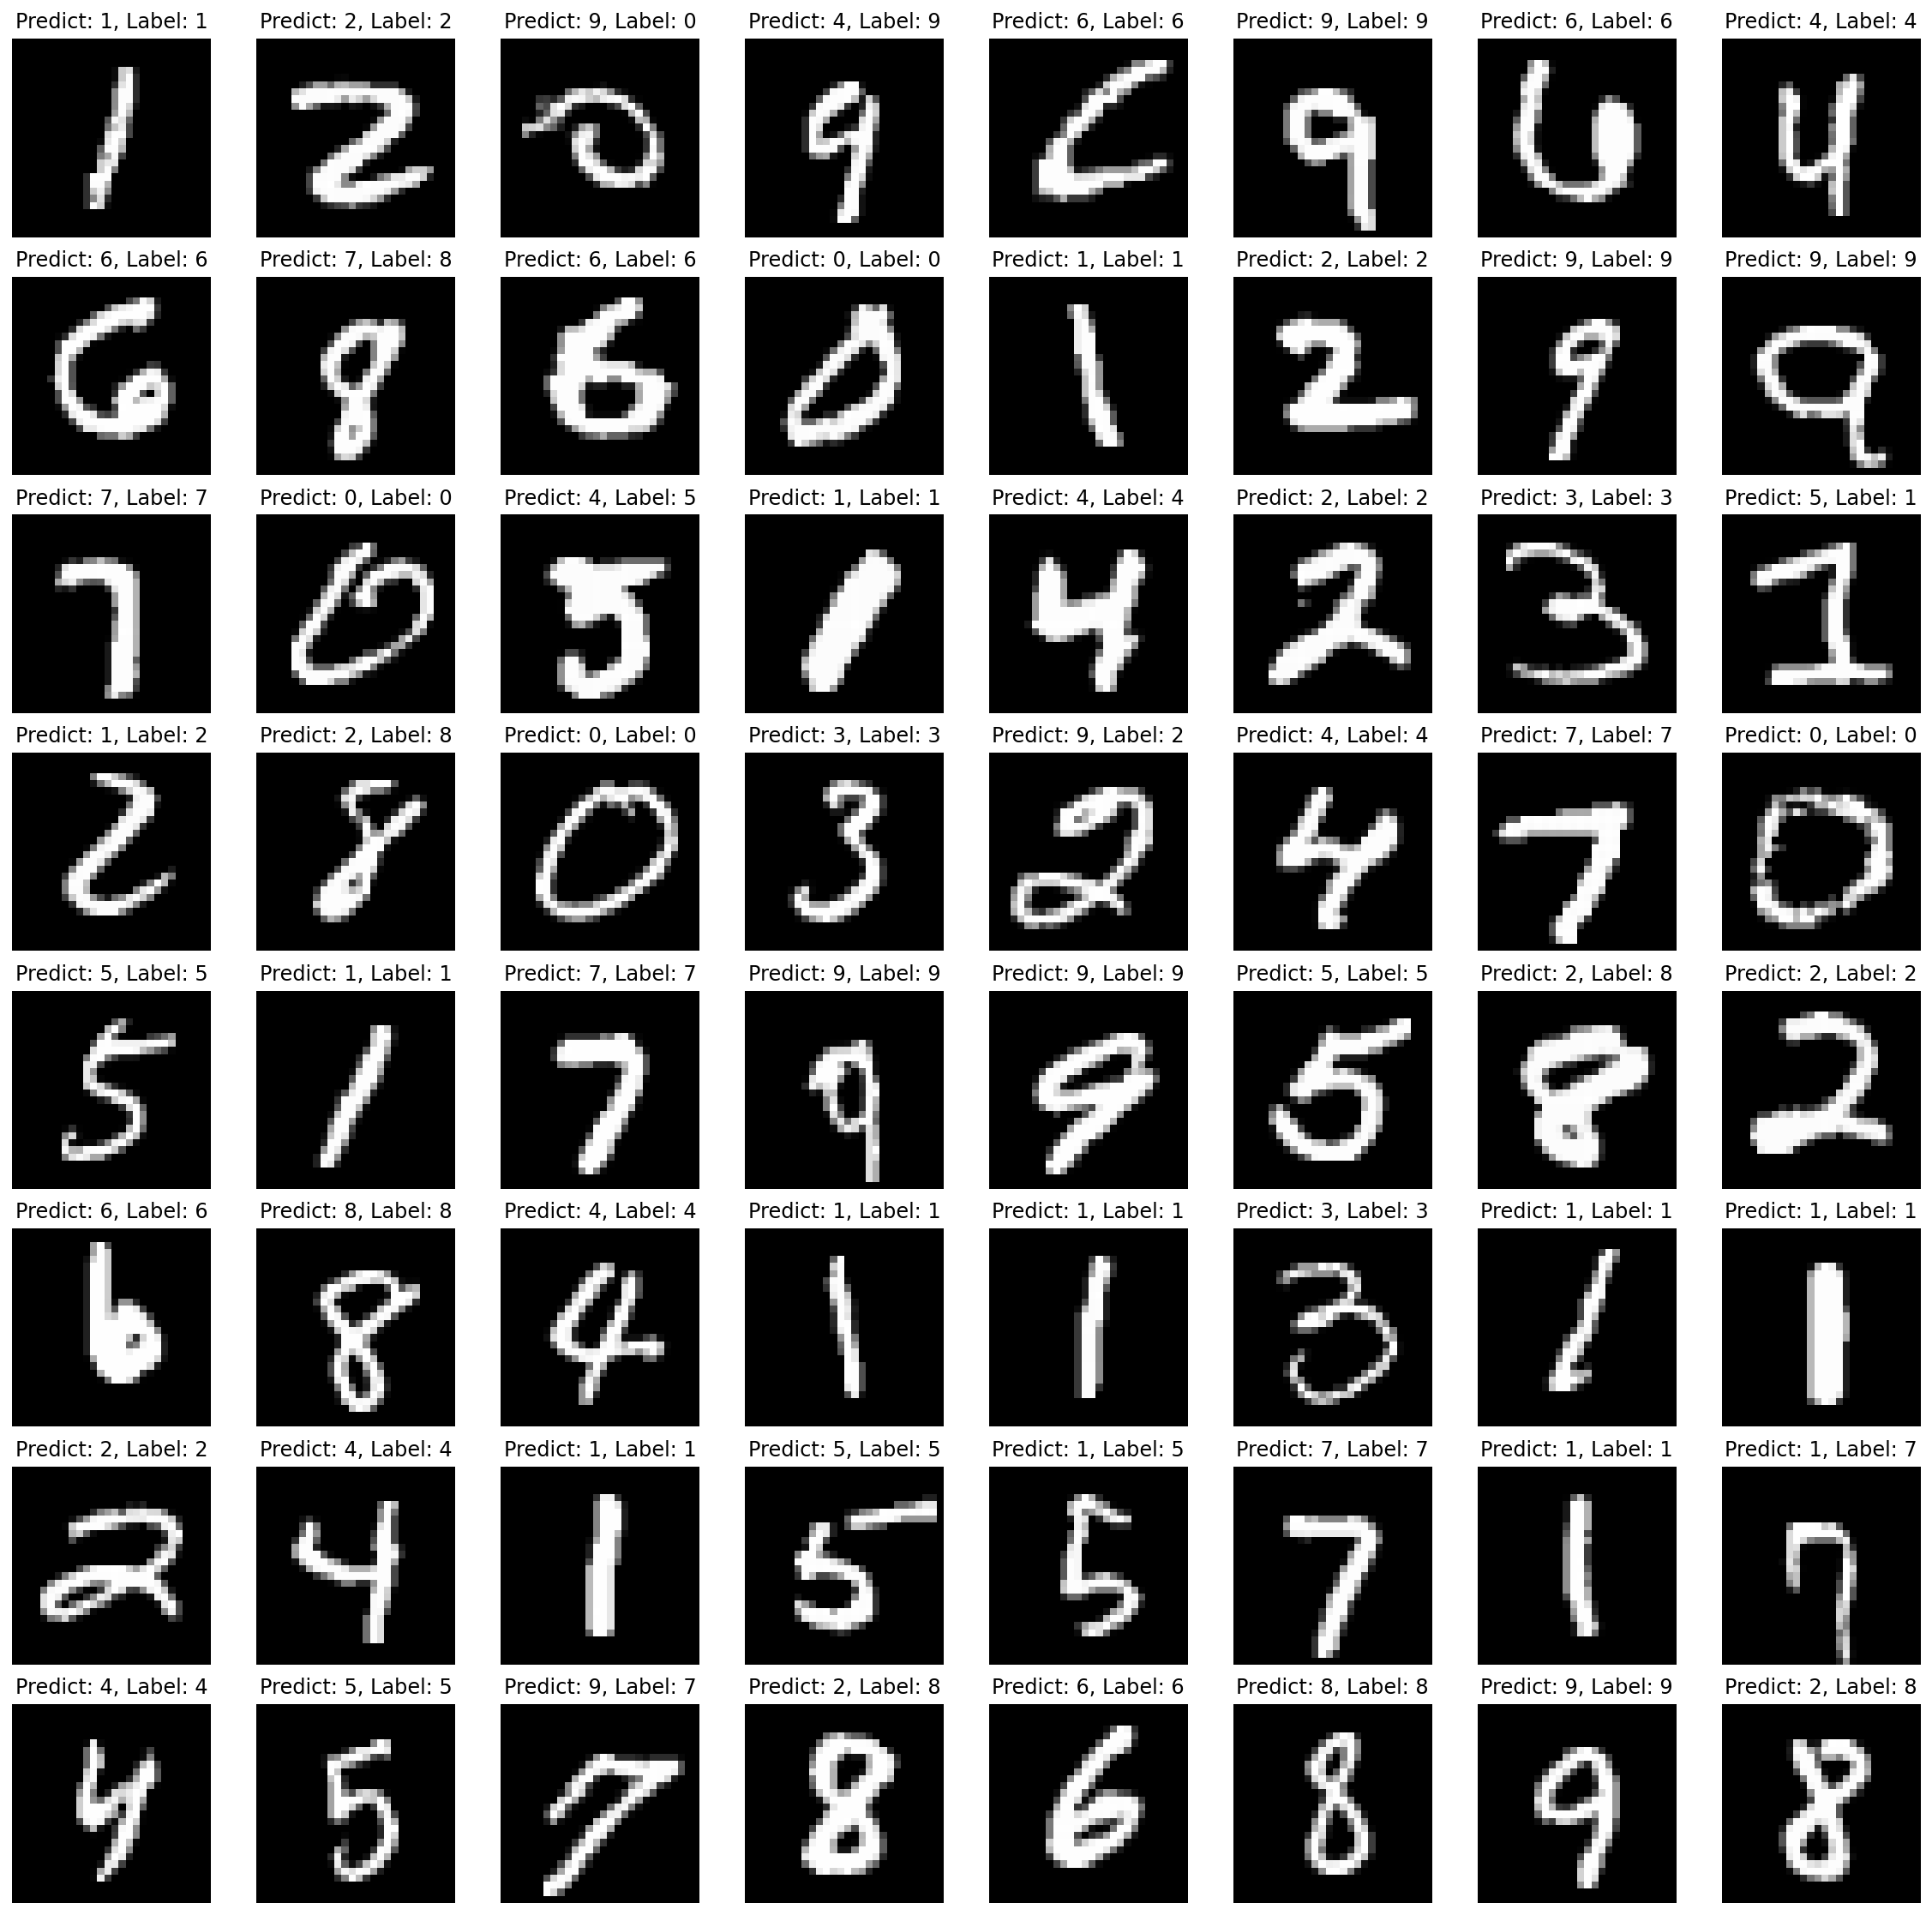

In [10]:
n_sample = 64
sample_indices = np.random.choice(len(mnist_test.targets), n_sample, replace=False)
test_x = mnist_test.data[sample_indices]
test_y = mnist_test.targets[sample_indices]

with torch.no_grad():
    model.eval()
    y_pred = model.forward(test_x.view(-1, 1, 28, 28).type(torch.float).to(device))
    model.train()

y_pred = y_pred.argmax(axis=1)

plt.figure(figsize=(20, 20))

for idx in range(n_sample):
    plt.subplot(8, 8, idx+1)
    plt.imshow(test_x[idx], cmap='gray')
    plt.axis('off')
    plt.title(f"Predict: {y_pred[idx]}, Label: {test_y[idx]}")

plt.show()